# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

## Set up Modelling Environment

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, cbm_report, plugin_c_curves, compare_ws3_cbm, compile_events
import pickle
# Import Module
from util_opt import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_maxstock, run_scenario
import libcbm

## Create and Run `ForestModel` instance

In [2]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
case_study = 'redchris'

In [3]:
fm = ws3.forest.ForestModel(model_name='redchris',
                            # model_path='./data/woodstock_model_files_redchris_test',
                            model_path='./data/woodstock_model_files_redchris',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

In [4]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

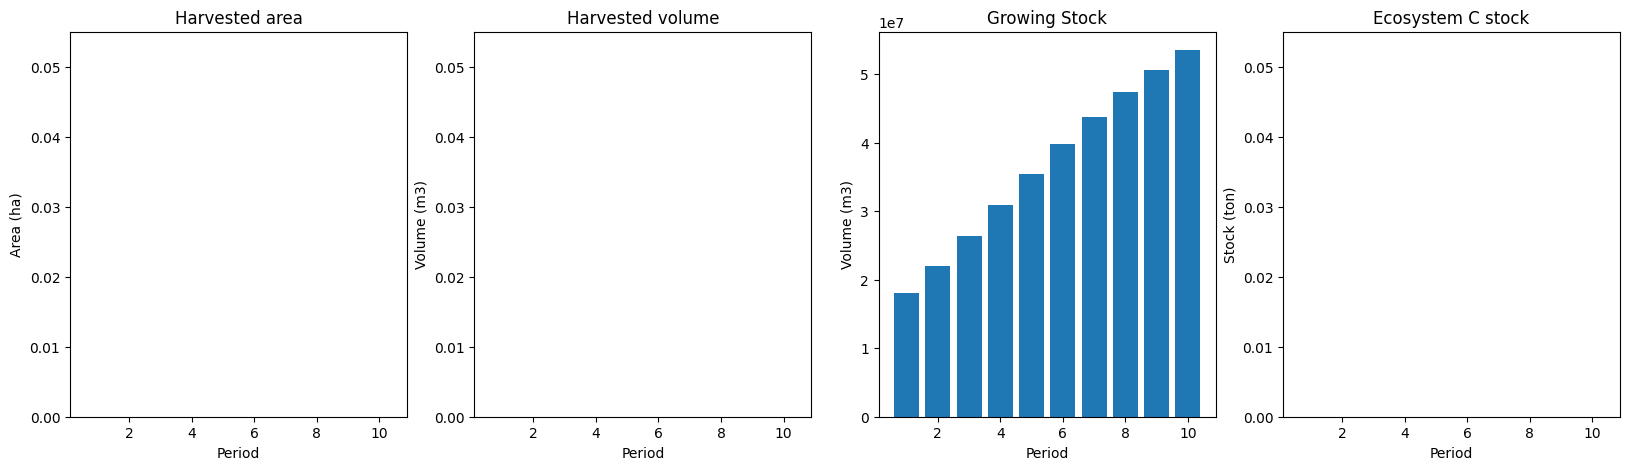

In [5]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## Hard-link `ForestModel` to `libcbm`

Prepare CBM input files

In [6]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [7]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping)

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [8]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [9]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

In [10]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]
decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [11]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,1.403745e+07,3.874220e+07,5.277965e+07,0.000000e+00,0.000000e+00,0.000000
1,1.423830e+07,3.863534e+07,5.287364e+07,8.850461e+05,9.790345e+05,-93988.459640
2,1.443963e+07,3.854026e+07,5.297989e+07,8.807935e+05,9.870460e+05,-106252.503460
3,1.464088e+07,3.845560e+07,5.309648e+07,8.778403e+05,9.944342e+05,-116593.865791
4,1.484254e+07,3.838034e+07,5.322289e+07,8.758588e+05,1.002263e+06,-126404.196888
...,...,...,...,...,...,...
96,2.990867e+07,4.437639e+07,7.428506e+07,1.161644e+06,1.352158e+06,-190514.038495
97,2.999184e+07,4.448176e+07,7.447360e+07,1.164035e+06,1.352573e+06,-188538.465314
98,3.007064e+07,4.458672e+07,7.465736e+07,1.166360e+06,1.350117e+06,-183756.250185


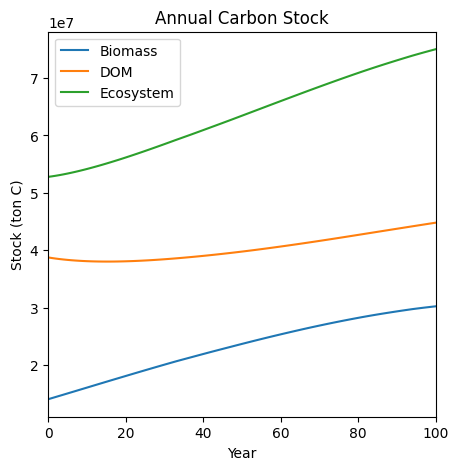

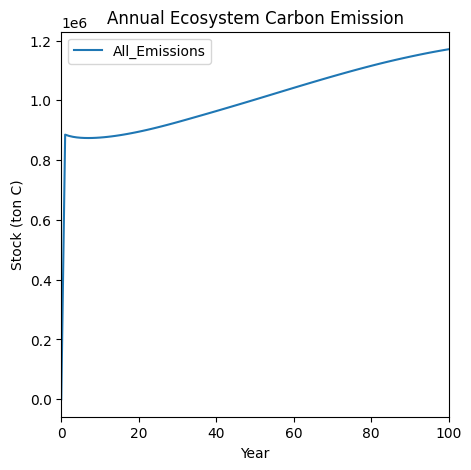

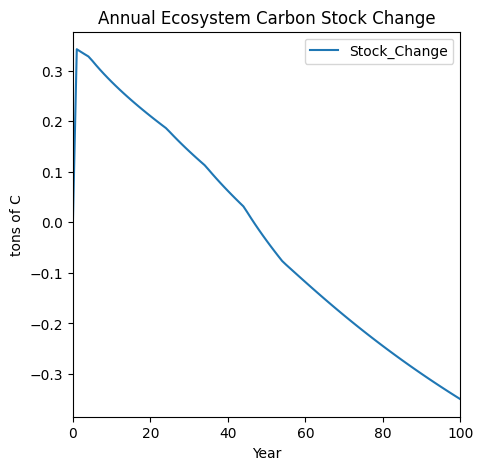

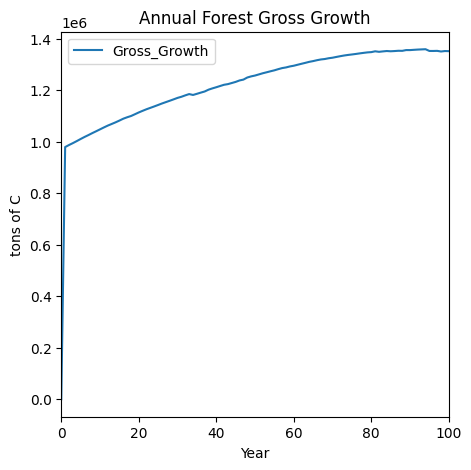

In [12]:
# Report Annual CBM Results
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

## Plug-in Carbon Yield Curves

In [13]:
# Read curves
c_curves_p = pd.read_pickle("./redchris_c_curves_p.pkl")
# c_curves_p = pd.read_pickle("./redchris_c_curves_p_exactmatch.pkl")
# c_curves_f = pd.read_pickle("redchris_c_curves_f.pkl") # Not created yet

In [14]:
# Plug carbon yield curves into forest model
plugin_c_curves(fm, c_curves_p, pools=sum_pools)
# plugin_c_curves(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=['net_fluxes', 'total_emissions'])

found match for mask ('?', '?', '?', '?', '1', '1')
found match for mask ('?', '?', '?', '?', '2', '2')
found match for mask ('?', '?', '?', '?', '3', '3')
found match for mask ('?', '?', '?', '?', '4', '4')
found match for mask ('?', '?', '?', '?', '5', '5')
found match for mask ('?', '?', '?', '?', '6', '6')
found match for mask ('?', '?', '?', '?', '7', '7')
found match for mask ('?', '?', '?', '?', '8', '8')
found match for mask ('?', '?', '?', '?', '9', '9')
found match for mask ('?', '?', '?', '?', '10', '10')
found match for mask ('?', '?', '?', '?', '11', '11')
found match for mask ('?', '?', '?', '?', '12', '12')
found match for mask ('?', '?', '?', '?', '16', '16')
found match for mask ('?', '?', '?', '?', '17', '17')
found match for mask ('?', '?', '?', '?', '18', '18')
found match for mask ('?', '?', '?', '?', '19', '19')
found match for mask ('?', '?', '?', '?', '20', '20')
found match for mask ('?', '?', '?', '?', '21', '21')
found match for mask ('?', '?', '?', '?', '22'

In [15]:
# Check if all carbon yield curves are plugged in well.
fm.yields

[(('?', '?', '?', '?', '?', '?'), '', []),
 (('?', '?', '?', '?', '7', '7'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7f518db099c0>),
   ('ecosystem', <ws3.core.Curve at 0x7f51808ba9b0>),
   ('biomass', <ws3.core.Curve at 0x7f51808ba8f0>),
   ('DOM', <ws3.core.Curve at 0x7f51808bad70>),
   ('ecosystem', <ws3.core.Curve at 0x7f51808ba9b0>),
   ('biomass', <ws3.core.Curve at 0x7f51808ba8f0>),
   ('DOM', <ws3.core.Curve at 0x7f51808bad70>)]),
 (('?', '?', '?', '?', '1', '1'),
  'a',
  [('s0304', <ws3.core.Curve at 0x7f518db099f0>),
   ('ecosystem', <ws3.core.Curve at 0x7f518098f9d0>),
   ('biomass', <ws3.core.Curve at 0x7f518098f400>),
   ('DOM', <ws3.core.Curve at 0x7f51808b9de0>)]),
 (('?', '?', '?', '?', '2', '2'),
  'a',
  [('s0304', <ws3.core.Curve at 0x7f518db0a3e0>),
   ('ecosystem', <ws3.core.Curve at 0x7f51808efbe0>),
   ('biomass', <ws3.core.Curve at 0x7f518098d600>),
   ('DOM', <ws3.core.Curve at 0x7f51808b8ac0>),
   ('ecosystem', <ws3.core.Curve at 0x7f51808efbe0>),
   ('bioma

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

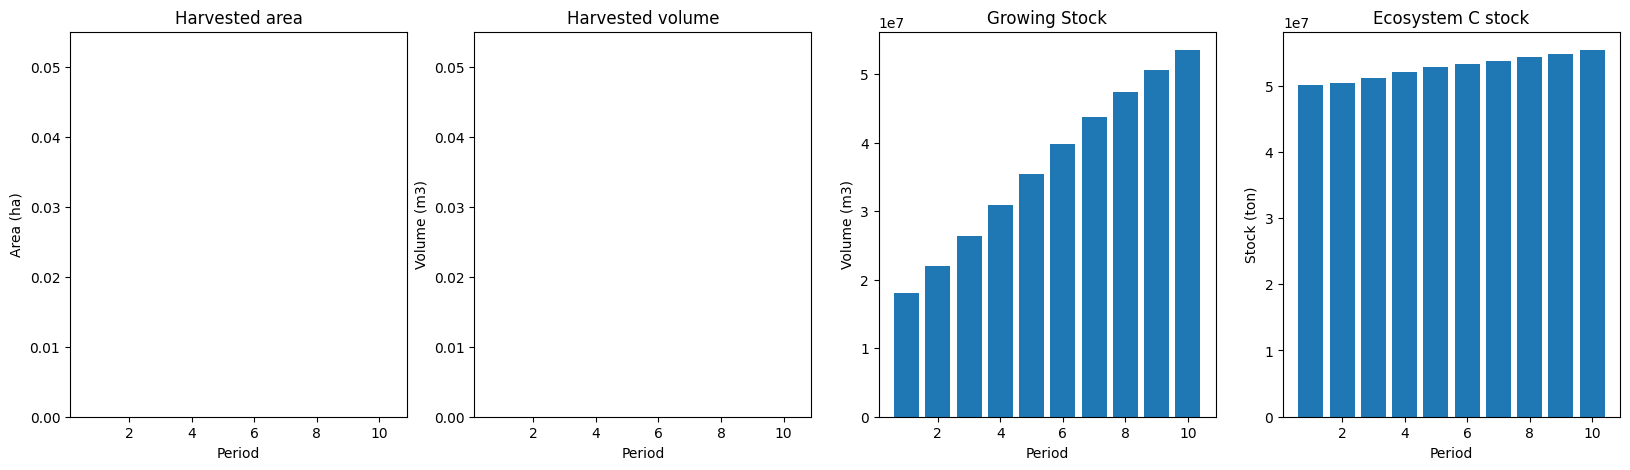

In [16]:
# Check the Forest Inventory of the ws3 Model without harvesting
df = compile_scenario_maxstock(fm)
plot_scenario_maxstock(df)

## No-harvest

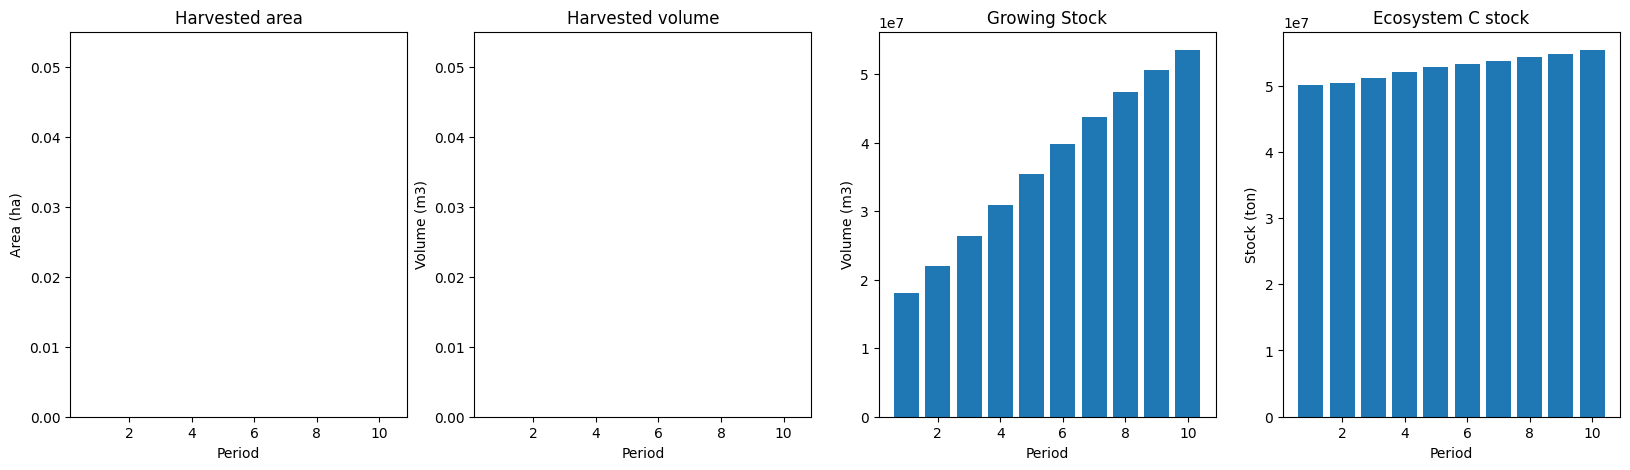

In [17]:
df = compile_scenario_maxstock(fm)
fig, ax = plot_scenario_maxstock(df)

In [18]:
#Define Basic Variables
softwood_volume_yname='swdvol' 
hardwood_volume_yname='hwdvol'
n_yield_vals=100

In [19]:
#Generate New Sit_events file
sit_events = compile_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [20]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [21]:
sit_events

,theme0,theme1,theme2,theme3,theme4,theme5,species,using_age_class,min_softwood_age,max_softwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year


In [22]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm_maxstock(sit_config, sit_tables, n_steps)

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,1.403745e+07,3.874220e+07,5.277965e+07,0.000000e+00,0.000000e+00,0.000000
1,1.423830e+07,3.863534e+07,5.287364e+07,8.850461e+05,9.790345e+05,-93988.459640
2,1.443963e+07,3.854026e+07,5.297989e+07,8.807935e+05,9.870460e+05,-106252.503460
3,1.464088e+07,3.845560e+07,5.309648e+07,8.778403e+05,9.944342e+05,-116593.865791
4,1.484254e+07,3.838034e+07,5.322289e+07,8.758588e+05,1.002263e+06,-126404.196888
...,...,...,...,...,...,...
96,2.990867e+07,4.437639e+07,7.428506e+07,1.161644e+06,1.352158e+06,-190514.038495
97,2.999184e+07,4.448176e+07,7.447360e+07,1.164035e+06,1.352573e+06,-188538.465314
98,3.007064e+07,4.458672e+07,7.465736e+07,1.166360e+06,1.350117e+06,-183756.250185


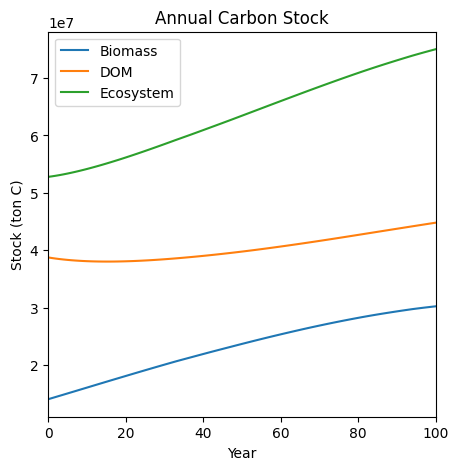

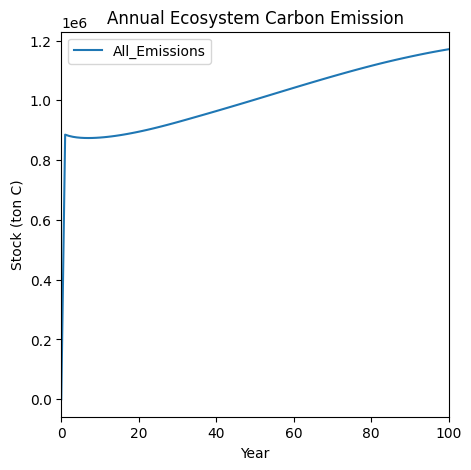

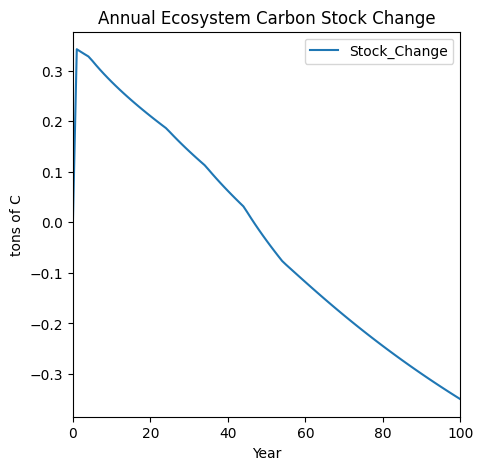

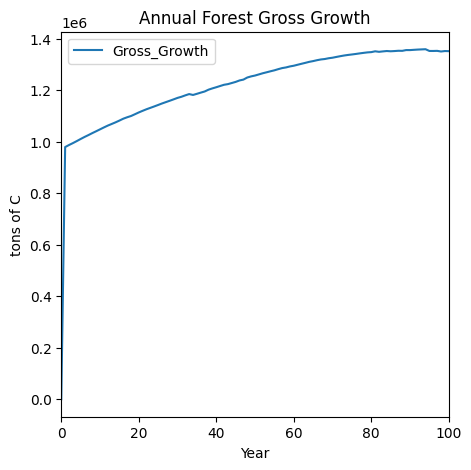

In [23]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

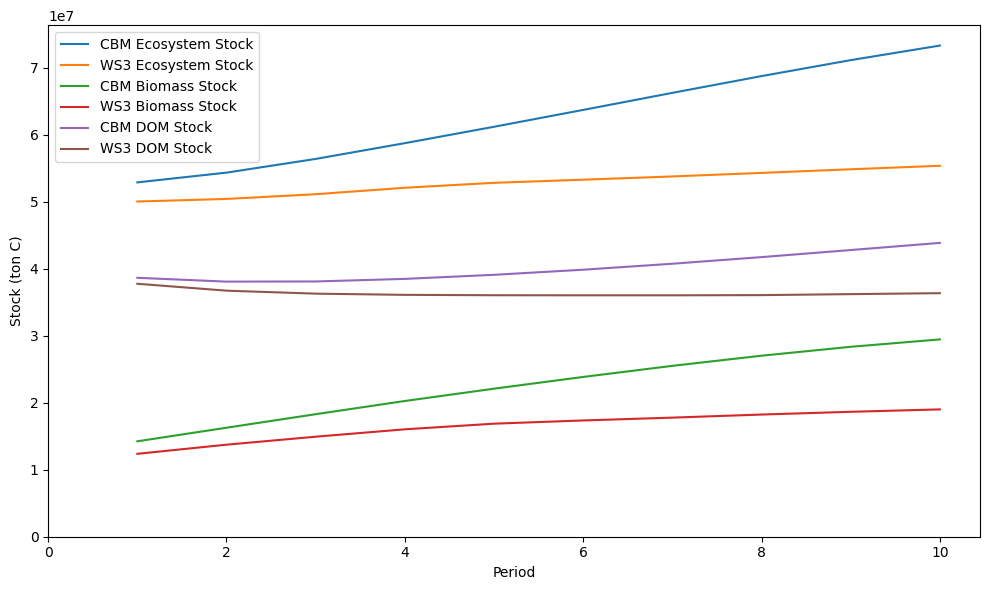

(   period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0       1   1.423830e+07  3.863534e+07  5.287364e+07      0.000000e+00
 1       2   1.626471e+07  3.806644e+07  5.433115e+07      1.457514e+06
 2       3   1.828427e+07  3.809009e+07  5.637435e+07      2.043203e+06
 3       4   2.025381e+07  3.847495e+07  5.872876e+07      2.354401e+06
 4       5   2.209131e+07  3.908150e+07  6.117281e+07      2.444050e+06
 5       6   2.384425e+07  3.984339e+07  6.368764e+07      2.514833e+06
 6       7   2.549859e+07  4.073631e+07  6.623491e+07      2.547267e+06
 7       8   2.701085e+07  4.172410e+07  6.873496e+07      2.500049e+06
 8       9   2.834004e+07  4.277782e+07  7.111786e+07      2.382909e+06
 9      10   2.944286e+07  4.384605e+07  7.328891e+07      2.171045e+06,
    period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0       1   1.237099e+07  3.774643e+07  5.001876e+07          0.000000
 1       2   1.373468e+07  3.671701e+07  5.040563e+07     38687

In [24]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots='whole')

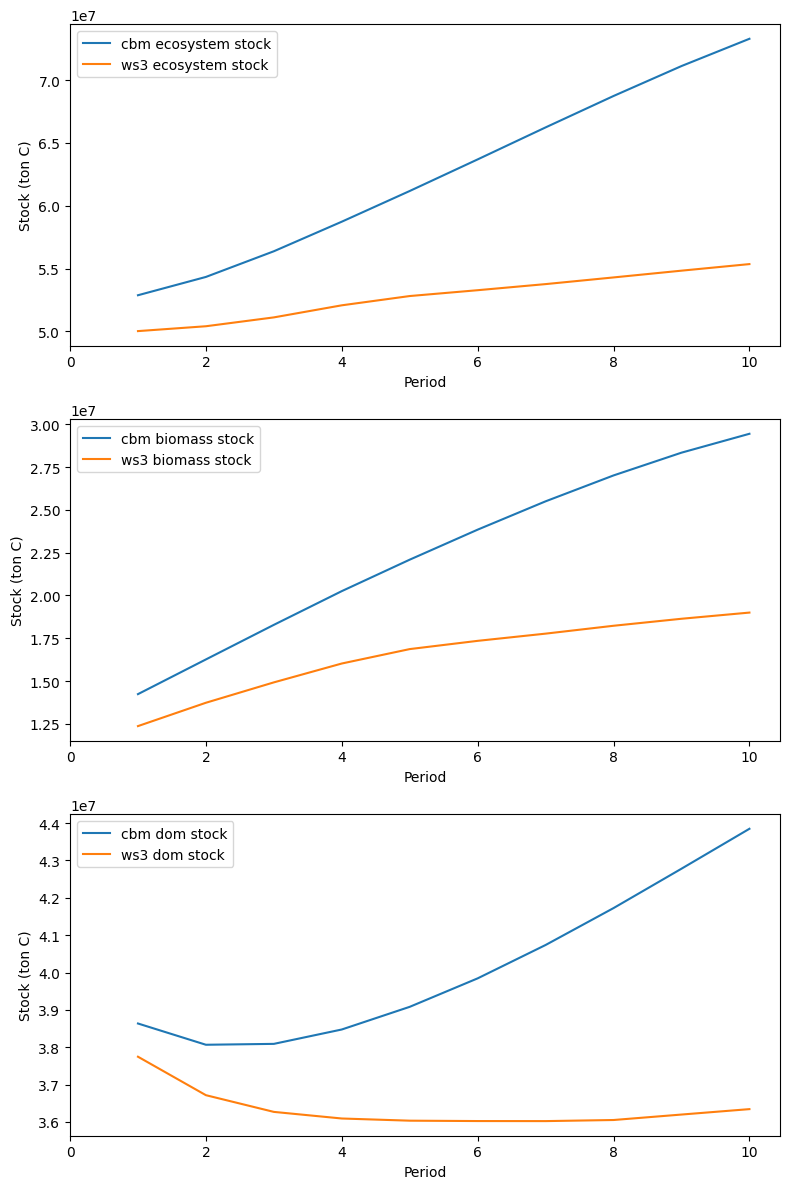

(   period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0       1   1.423830e+07  3.863534e+07  5.287364e+07      0.000000e+00
 1       2   1.626471e+07  3.806644e+07  5.433115e+07      1.457514e+06
 2       3   1.828427e+07  3.809009e+07  5.637435e+07      2.043203e+06
 3       4   2.025381e+07  3.847495e+07  5.872876e+07      2.354401e+06
 4       5   2.209131e+07  3.908150e+07  6.117281e+07      2.444050e+06
 5       6   2.384425e+07  3.984339e+07  6.368764e+07      2.514833e+06
 6       7   2.549859e+07  4.073631e+07  6.623491e+07      2.547267e+06
 7       8   2.701085e+07  4.172410e+07  6.873496e+07      2.500049e+06
 8       9   2.834004e+07  4.277782e+07  7.111786e+07      2.382909e+06
 9      10   2.944286e+07  4.384605e+07  7.328891e+07      2.171045e+06,
    period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0       1   1.237099e+07  3.774643e+07  5.001876e+07          0.000000
 1       2   1.373468e+07  3.671701e+07  5.040563e+07     38687

In [25]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, plots='individual')

## Maximize the Total System Carbon Stock

In [26]:
#Define constants from product carbon estimation

# Define the product half-lives（>0.69)
half_life_solid_wood = 30
half_life_paper = 2

# Define the allocation distribution
proportion_solid_wood = 0.5

# Define the displacement factor 
displacement_factor = 2.2

In [30]:
def select_obj(obj_mode):
    print(f"Selected scenario: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='max_st',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Objective:', index=2, options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='max_st')

In [35]:
obj_mode = obj_dropdown.value

In [36]:
from util_opt import cmp_c_ss, cmp_c_se

running no constraints scenario
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3667 rows, 34533 columns and 34533 nonzeros
Model fingerprint: 0xd73ee84e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 5e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 3667 rows and 34533 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -6.1406947e+07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.01 work units)
Optimal objective -6.140694722e+07


[(('tsa04', '1', '2', '304', '2', '2'),
  134,
  4.860524571605095,
  'harvest',
  10,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  141,
  33.986583987596774,
  'harvest',
  10,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  146,
  4.975814841555783,
  'harvest',
  10,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  147,
  33.64134206351518,
  'harvest',
  10,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  152,
  78.93623033715156,
  'harvest',
  10,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  153,
  19.034573330040065,
  'harvest',
  10,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  154,
  84.50523081285785,
  'harvest',
  10,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  155,
  11.659279177641668,
  'harvest',
  10,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  156,
  72.54342582190898,
  'harvest',
  10,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  157,
  85.9022285535543,
  '

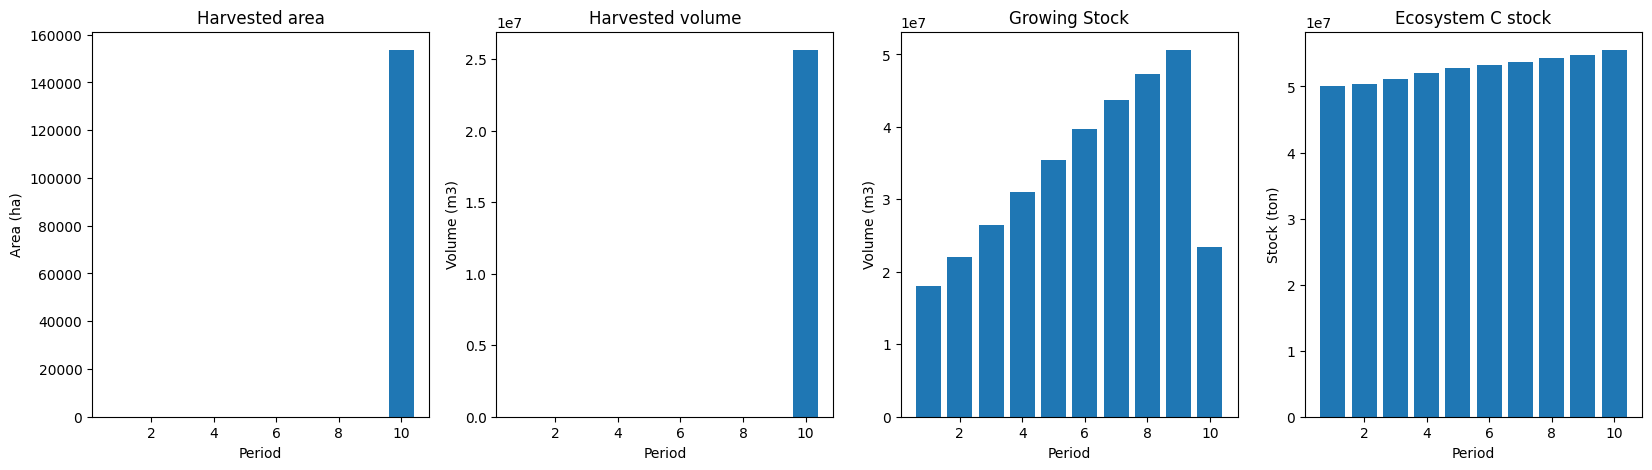

In [37]:
# Maximize Harvest
run_scenario(fm, obj_mode , 'no_cons')

running business as usual scenario for the Red Chris mining site,
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel Core Processor (Broadwell, IBRS), instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3709 rows, 34533 columns and 459071 nonzeros
Model fingerprint: 0xe73e2921
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  Objective range  [2e+01, 5e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 2010 rows and 2005 columns
Presolve time: 0.18s
Presolved: 1699 rows, 32528 columns, 422291 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.066e+04
 Factor NZ  : 8.155e+04 (roughly 14 MB of memory)
 Factor Ops : 4.060e+06 (less than 1 second per iteration)
 Threads    : 14

                  Objective                Res

[(('tsa04', '1', '2', '304', '2', '2'),
  150,
  289.88814072341677,
  'harvest',
  1,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  152,
  30.84728737415105,
  'harvest',
  1,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  153,
  24.401411933673284,
  'harvest',
  1,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  154,
  55.20760291508005,
  'harvest',
  1,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  157,
  54.467815434084365,
  'harvest',
  1,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  158,
  95.28727939440346,
  'harvest',
  1,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  159,
  88.33851106600585,
  'harvest',
  1,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  160,
  38.709458289910266,
  'harvest',
  1,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  161,
  75.77416502241697,
  'harvest',
  1,
  '_existing'),
 (('tsa04', '1', '2', '304', '2', '2'),
  162,
  27.862971910259507,
  'harves

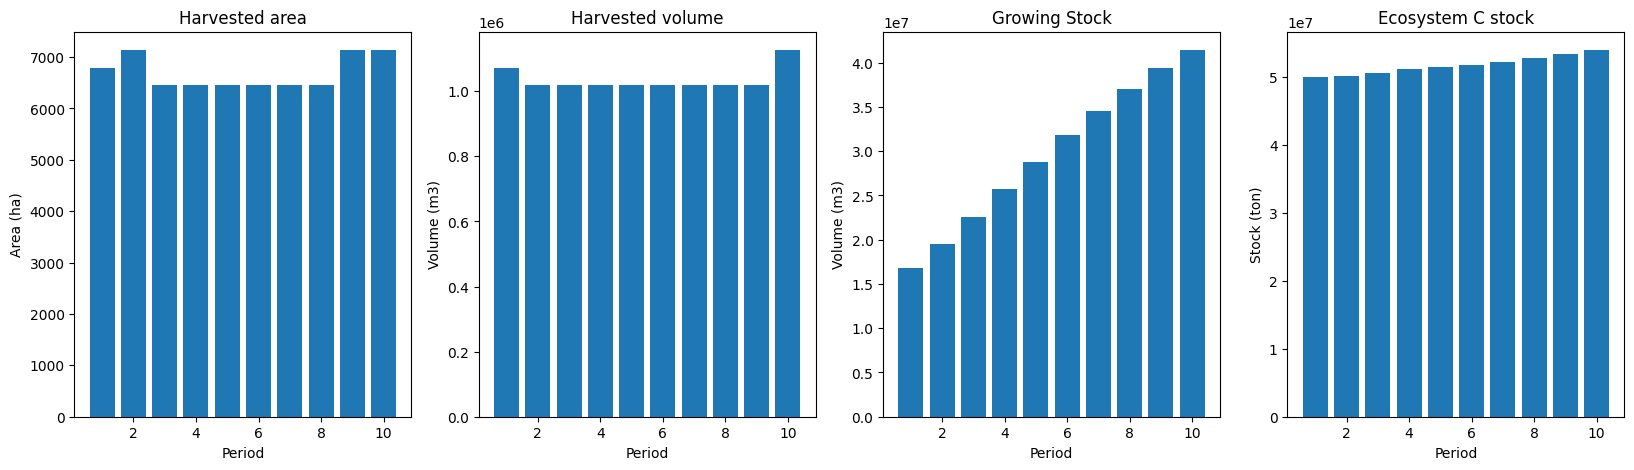

In [38]:
run_scenario(fm, obj_mode , 'bau_redchrs')